<a href="https://www.kaggle.com/code/subhadipde2000/context-aware-q-a-gemma-3-fine-tuning-with-lora?scriptVersionId=240258033" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Installing/Updating Required Libraries:

In [1]:
!pip install -q -U keras-nlp
!pip install -q -U keras>=3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 792.1/792.1 kB 23.6 MB/s eta 0:00:00


# Importing Required Libraries:

In [2]:
import os
import re
import json
import keras
import random
import warnings
import keras_nlp
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import display, Markdown

2025-05-17 13:23:36.969613: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747488217.242168      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747488217.327270      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
warnings.filterwarnings("ignore")

# Setting Up the Keras Backend:

In [4]:
os.environ["KERAS_BACKEND"] = "jax"
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "1"
os.environ["JAX_PLATFORMS"] = ""

# Loading the Data:

In [5]:
data = []

with open('/kaggle/input/databricks-dolly-15k/databricks-dolly-15k.jsonl') as file:
    for line in file:
        record = json.loads(line)

        # Filtering out examples without context
        if not record["context"]:
            continue
            
        record_dict = {"prompts" : "", "responses" : ""}
        record_dict["prompts"] = record["instruction"]
        context = re.sub(r'\[\d+\]', '', record['context']) # Removing bracketed Wikipedia citation numbers from context
        record_dict["prompts"] += f" \n\nContext: {context}"
        record_dict["responses"] = record["response"]
        
        data.append(record_dict)

# Exploratory Data Analysis:

In [6]:
def plot():
    context_lengths = []
    response_lengths = []
    
    for i in range(len(data)):
        context_lengths.append(len(data[i]["prompts"].split("\n\nContext: ")[-1].split()))
        response_lengths.append(len(data[i]["responses"].split()))

    df = pd.DataFrame({"context lengths":context_lengths, "response lengths":response_lengths})
    
    fig, axes = plt.subplots(2, 1, figsize=(8, 8), dpi=250)
    sns.histplot(data=df, x="context lengths", bins=500, ax=axes[0], kde=True).set_title("Distribution of context lengths (number of words)")
    sns.histplot(data=df, x="response lengths", bins=1000, ax=axes[1], kde=True).set_title("Distribution of response lengths (number of words)")
    axes[0].set_xlim(0, 1500)
    axes[1].set_xlim(0, 400)
    plt.subplots_adjust(hspace=0.5)
    plt.show()
    return

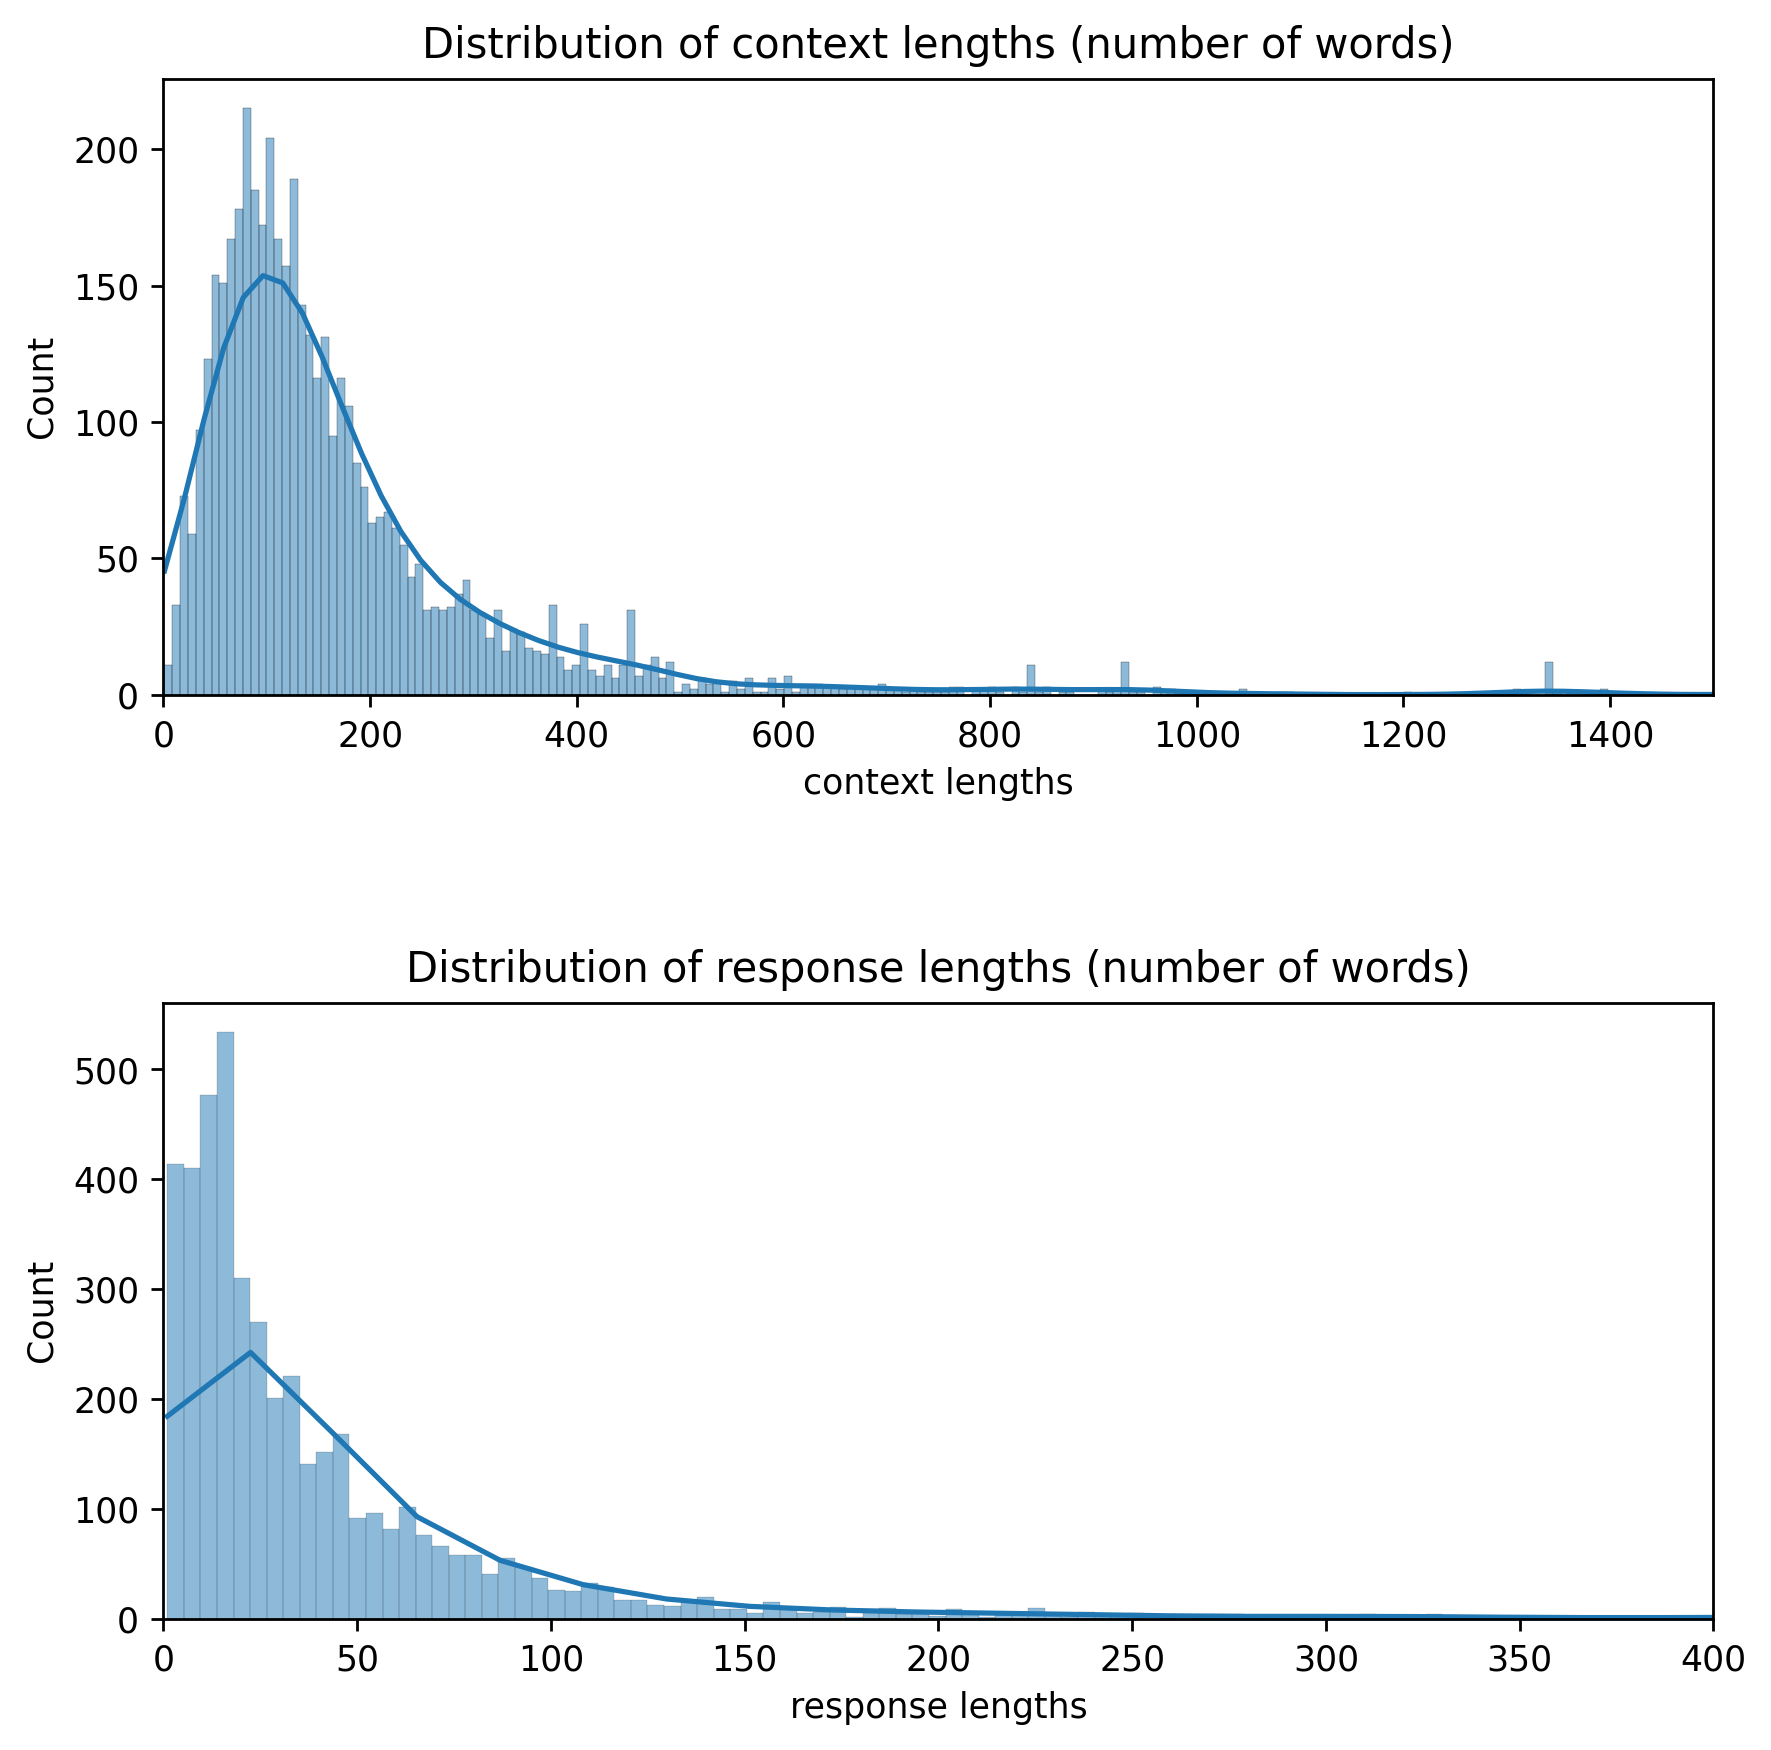

In [7]:
plot()

# Function for Coloring and Formatting the Texts:

In [8]:
def colorize_text(text):
    for word, color in zip(["Question: ", "Context: ", "Answer: ", "System: "], ["crimson", "cyan", "lightgreen", "aquamarine"]):
        text = text.replace(f"{word}", f"<font color='{color}' size='4'><strong>{word}</strong></font>")
    return text



def colorize_text_from_dict(text_dict):
    text = ""

    for key, value in text_dict.items():
        if key == "prompts":
            text += f"Question: {value}\n\n"
        elif key == "responses":
            text += f"Answer: {value}\n\n"

    text = colorize_text(text)
    
    return text

In [9]:
# Visualizing a random text from the corpus
n = random.randint(0, len(data))
text = f"<center><font color='Yellow' size='6'><strong>Example {n}:</strong></font></center>\n\n"
text += colorize_text_from_dict(data[n])
display(Markdown(text))

<center><font color='Yellow' size='6'><strong>Example 4357:</strong></font></center>

<font color='crimson' size='4'><strong>Question: </strong></font>How did Chiune Sugihara save lives? 

<font color='cyan' size='4'><strong>Context: </strong></font>Chiune Sugihara (杉原 千畝, Sugihara Chiune, 1 January 1900 – 31 July 1986) was a Japanese diplomat who served as vice-consul for the Japanese Empire in Kaunas, Lithuania. During the Second World War, Sugihara helped thousands of Jews flee Europe by issuing transit visas to them so that they could travel through Japanese territory, risking his job and the lives of his family. The fleeing Jews were refugees from German-occupied Western Poland and Soviet-occupied Eastern Poland, as well as residents of Lithuania. In 1985, the State of Israel honored Sugihara as one of the Righteous Among the Nations for his actions. He is the only Japanese national to have been so honored. The year 2020 was "The Year Chiune Sugihara" in Lithuania. It has been estimated as many as 100,000 people alive today are the descendants of the recipients of Sugihara visas.

<font color='lightgreen' size='4'><strong>Answer: </strong></font>He issued transit visas to Jews fleeing Europe during World War II, so they could travel through Japanese territory.



# Prompt Template for Context Aware Q&A:

In [10]:
template = """System: 
You are an AI assistant tasked with answering questions based solely on the provided context. Carefully read the following Context and Question. Your answer must be derived only from the information present in the Context. Do not use any external knowledge or make assumptions beyond what is explicitly stated in the Context.
If the answer to the Question cannot be found within the Context, you must explicitly state: 'The answer cannot be found in the provided context.'

Question: 
{question}

Context: 
{context}

Answer: \n
"""

# Building TensorFlow Dataset:

In [11]:
random.shuffle(data) # Shuffling the list
dataset = data[:500] # Taking the first 500 examples for faster training
test_dataset = data[500:]

In [12]:
def build_tf_dataset(text_dict_list):
    AUTO = tf.data.AUTOTUNE
    options = tf.data.Options()
    options.experimental_deterministic = False

    for item in text_dict_list:
        question = item["prompts"].split("\n\nContext: ")[0]
        context = item["prompts"].split("\n\nContext: ")[-1]
        item["prompts"] = template.format(question=question, context=context)
    
    dataset = tf.data.Dataset.from_generator(
        lambda: (item for item in text_dict_list),
        output_signature={
            "prompts": tf.TensorSpec(shape=(), dtype=tf.string),
            "responses": tf.TensorSpec(shape=(), dtype=tf.string),
        }
    ).cache()

    dataset = dataset.shuffle(1024, seed=42)
    dataset = dataset.with_options(options).batch(1).prefetch(AUTO)

    return dataset

In [13]:
dataset = build_tf_dataset(dataset)

I0000 00:00:1747488236.817909      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


# Loading the Gemma 3 Model with 1 Billion Parameters:

In [14]:
gemma3_1b = keras_nlp.models.Gemma3CausalLM.from_preset("gemma3_1b")
gemma3_1b.summary()

normalizer.cc(51) LOG(INFO) precompiled_charsmap is empty. use identity normalization.


Preprocessor: "gemma3_causal_lm_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                                  ┃                                   Config ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ gemma3_tokenizer (Gemma3Tokenizer)                            │                      Vocab size: 262,144 │
└───────────────────────────────────────────────────────────────┴──────────────────────────────────────────┘

Model: "gemma3_causal_lm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ gemma3_backbone               │ (None, None, 1152)        │     999,885,952 │ padding_mask[0][0],        │
│ (Gemma3Backbone)              │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_embedding               │ (None, None, 262144)      │     301,989,888 │ gemma3_backbone[0][0]      │
│ (ReversibleEmbedding)         │                           │                 │                            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 999,885,952 (3.72 GB)

 Trainable params: 999,885,952 (3.72 GB)

 Non-trainable params: 0 (0.00 B)

# Inferenece Before Fine-tuning:

In [15]:
def generate_inference(example_num=None):
    
    if example_num == None or example_num >= len(test_dataset):
        example_num = random.randint(0, len(test_dataset))

    example = test_dataset[example_num]
    question = example["prompts"].split("\n\nContext: ")[0].strip()
    context = example["prompts"].split("\n\nContext: ")[-1].strip()
    answer = example["responses"]

    input_prompt = template.format(question=question, context=context)
    max_length = 2 * len(input_prompt.split())
    response = gemma3_1b.generate(input_prompt, max_length=max_length)
    response = response.split("Answer: \n")[-1].strip()

    colored_text = f"<center><font color='Yellow' size='6'><strong>Input Prompt:</strong></font></center>\n\n"
    colored_text += input_prompt
    colored_text += f"<center><font color='Yellow' size='6'><strong>Answer as per Dataset:</strong></font></center>\n\n{answer}\n\n"
    colored_text += f"<center><font color='Yellow' size='6'><strong>Gemma 3 Response:</strong></font></center>\n\n{response}"
    
    return colorize_text(colored_text)

In [16]:
display(Markdown(generate_inference()))

I0000 00:00:1747488293.384383      19 service.cc:148] XLA service 0x406c5420 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747488293.385596      19 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1747488299.180732      19 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1747488309.476064      19 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


<center><font color='Yellow' size='6'><strong>Input Prompt:</strong></font></center>

<font color='aquamarine' size='4'><strong>System: </strong></font>
You are an AI assistant tasked with answering questions based solely on the provided context. Carefully read the following Context and Question. Your answer must be derived only from the information present in the Context. Do not use any external knowledge or make assumptions beyond what is explicitly stated in the Context.
If the answer to the Question cannot be found within the Context, you must explicitly state: 'The answer cannot be found in the provided context.'

<font color='crimson' size='4'><strong>Question: </strong></font>
Who composed the theme song for the movie Marvin's Room?

<font color='cyan' size='4'><strong>Context: </strong></font>
Marvin's Room is a 1996 American drama film directed by Jerry Zaks. The script was written by John Guare and based on the play of the same name by Scott McPherson, who died in 1992. McPherson had completed a screenplay for a film version before he died; however Guare was hired to update it when the film eventually started production years later.

It stars Meryl Streep, Leonardo DiCaprio, Diane Keaton, Robert De Niro, Hume Cronyn, Gwen Verdon, Hal Scardino and Dan Hedaya. Original music for the film was composed by Rachel Portman. Carly Simon wrote and performed the theme song "Two Little Sisters", with Meryl Streep adding background vocals.

<font color='lightgreen' size='4'><strong>Answer: </strong></font>

<center><font color='Yellow' size='6'><strong>Answer as per Dataset:</strong></font></center>

The musician that composed the original music for the Marvin's room was Rachel Portoman, and Carly Simon wrote and performed the song.

<center><font color='Yellow' size='6'><strong>Gemma 3 Response:</strong></font></center>

Rachel Portman composed the theme song for the film Marvin's Room.

Explanation: 
Rachel Portman is a British composer and pianist who has composed music for numerous films, including the 1996 film Marvin's Room. The film is based on the play of the same name by Scott McPherson, who died in 1992. The film was directed by Jerry Zaks and stars Meryl Streep, Leonardo DiCaprio, Diane Keaton, Robert De Niro, Hume Cronyn, Gwen Verdon, Hal Scardino and Dan Hedaya.

The film was released in 1996 and received mixed reviews from critics. It was

In [17]:
display(Markdown(generate_inference()))

<center><font color='Yellow' size='6'><strong>Input Prompt:</strong></font></center>

<font color='aquamarine' size='4'><strong>System: </strong></font>
You are an AI assistant tasked with answering questions based solely on the provided context. Carefully read the following Context and Question. Your answer must be derived only from the information present in the Context. Do not use any external knowledge or make assumptions beyond what is explicitly stated in the Context.
If the answer to the Question cannot be found within the Context, you must explicitly state: 'The answer cannot be found in the provided context.'

<font color='crimson' size='4'><strong>Question: </strong></font>
Where is Landscape Arch?

<font color='cyan' size='4'><strong>Context: </strong></font>
Landscape Arch is a natural rock arch in Arches National Park in the U.S. state of Utah. With a length of 290.1 feet (88.4 m), it is the longest natural arch in the park and the United States, and the fifth-longest in the world. Landscape Arch was named by Frank Beckwith, who explored the area in the winter of 1933–34 as the leader of a scientific expedition.

<font color='lightgreen' size='4'><strong>Answer: </strong></font>

<center><font color='Yellow' size='6'><strong>Answer as per Dataset:</strong></font></center>

Landscape Arch is a natural rock arch in Arches National Park in the U.S. state of Utah.

<center><font color='Yellow' size='6'><strong>Gemma 3 Response:</strong></font></center>

The answer to the question is: 
Landscape Arch is located in Arches National Park in the U.S. state of Utah.

Explanation: 
The answer to the question is Landscape Arch, which is located in Arches National Park in the U.S. state of Utah. The park is known for its unique landscape of natural arches, canyons, and mesas, and Landscape Arch is one of the most famous and photographed arches in the park. The arch is located

In [18]:
display(Markdown(generate_inference()))

<center><font color='Yellow' size='6'><strong>Input Prompt:</strong></font></center>

<font color='aquamarine' size='4'><strong>System: </strong></font>
You are an AI assistant tasked with answering questions based solely on the provided context. Carefully read the following Context and Question. Your answer must be derived only from the information present in the Context. Do not use any external knowledge or make assumptions beyond what is explicitly stated in the Context.
If the answer to the Question cannot be found within the Context, you must explicitly state: 'The answer cannot be found in the provided context.'

<font color='crimson' size='4'><strong>Question: </strong></font>
Given this paragraph on LeBron James' early career, when did he win his first NBA MVP?

<font color='cyan' size='4'><strong>Context: </strong></font>
James grew up playing basketball for St. Vincent–St. Mary High School in his hometown of Akron, Ohio. He was heavily touted by the national media as a future NBA superstar. A prep-to-pro, he was selected by the Cleveland Cavaliers with the first overall pick of the 2003 NBA draft. Named the 2004 NBA Rookie of the Year, he soon established himself as one of the league's premier players, leading the Cavaliers to their first NBA Finals appearance in 2007 and winning the NBA MVP award in 2009 and 2010. After failing to win a championship with Cleveland, James left in 2010 as a free agent to join the Miami Heat; this was announced in a nationally televised special titled The Decision and is among the most controversial free agency moves in sports history.

<font color='lightgreen' size='4'><strong>Answer: </strong></font>

<center><font color='Yellow' size='6'><strong>Answer as per Dataset:</strong></font></center>

LeBron James won his first NBA MVP in 2009.

<center><font color='Yellow' size='6'><strong>Gemma 3 Response:</strong></font></center>

The answer to the question is: 
2009

Explanation: 
The answer to the question is: 
2009

Explanation: 
The answer to the question is: 
2009

Explanation: 
The answer to the question is: 
2009

Explanation: 
The answer to the question is: 
2009

Explanation: 
The answer to the question is: 
2009

Explanation: 
The answer to the question is: 
2009

Explanation: 
The answer to the question is: 
2009

Explanation: 
The answer to the question is: 
2009

# Fine-tuning with LoRA:

In [19]:
gemma3_1b.backbone.enable_lora(rank=4)
gemma3_1b.summary()

Preprocessor: "gemma3_causal_lm_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                                  ┃                                   Config ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ gemma3_tokenizer (Gemma3Tokenizer)                            │                      Vocab size: 262,144 │
└───────────────────────────────────────────────────────────────┴──────────────────────────────────────────┘

Model: "gemma3_causal_lm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ gemma3_backbone               │ (None, None, 1152)        │   1,000,538,240 │ padding_mask[0][0],        │
│ (Gemma3Backbone)              │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_embedding               │ (None, None, 262144)      │     301,989,888 │ gemma3_backbone[0][0]      │
│ (ReversibleEmbedding)         │                           │                 │                            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 1,000,538,240 (3.73 GB)

 Trainable params: 652,288 (2.49 MB)

 Non-trainable params: 999,885,952 (3.72 GB)

In [20]:
gemma3_1b.preprocessor.sequence_length = 512

optimizer = keras.optimizers.AdamW(
    learning_rate=5e-5,
    weight_decay=0.01,
)

# Exclude layernorm and bias terms from decay.
optimizer.exclude_from_weight_decay(var_names=["bias", "scale"])

In [21]:
# Model Compilation
gemma3_1b.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=optimizer,
    weighted_metrics=[keras.metrics.SparseCategoricalAccuracy()],
)

In [22]:
# Model Training
history = gemma3_1b.fit(dataset, epochs=25)

Epoch 1/25


W0000 00:00:1747488462.491056      74 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


500/500 ━━━━━━━━━━━━━━━━━━━━ 262s 323ms/step - loss: 0.1568 - sparse_categorical_accuracy: 0.6912
Epoch 2/25
500/500 ━━━━━━━━━━━━━━━━━━━━ 162s 323ms/step - loss: 0.1694 - sparse_categorical_accuracy: 0.7034
Epoch 3/25
500/500 ━━━━━━━━━━━━━━━━━━━━ 162s 323ms/step - loss: 0.1816 - sparse_categorical_accuracy: 0.6872
Epoch 4/25
500/500 ━━━━━━━━━━━━━━━━━━━━ 162s 323ms/step - loss: 0.1601 - sparse_categorical_accuracy: 0.7065
Epoch 5/25
500/500 ━━━━━━━━━━━━━━━━━━━━ 161s 322ms/step - loss: 0.1468 - sparse_categorical_accuracy: 0.7126
Epoch 6/25
500/500 ━━━━━━━━━━━━━━━━━━━━ 162s 323ms/step - loss: 0.1456 - sparse_categorical_accuracy: 0.7128
Epoch 7/25
500/500 ━━━━━━━━━━━━━━━━━━━━ 162s 323ms/step - loss: 0.1498 - sparse_categorical_accuracy: 0.7087
Epoch 8/25
500/500 ━━━━━━━━━━━━━━━━━━━━ 162s 323ms/step - loss: 0.1489 - sparse_categorical_accuracy: 0.7146
Epoch 9/25
500/500 ━━━━━━━━━━━━━━━━━━━━ 162s 324ms/step - loss: 0.1249 - sparse_categorical_accuracy: 0.7385
Epoch 10/25
500/500 ━━━━━━━━━━

# Plotting Training Metric:

In [23]:
def plot_model_metric(metric):
    plt.figure(dpi=120)
    plt.plot(history.history[metric], label=metric)
    # plt.plot(history.history[f'val_{metric}'], label=f'val_{metric}')
    plt.xlabel('Epoch')
    plt.ylabel(metric)
    plt.legend()
    plt.title(f'{metric} over Epochs')
    plt.show();

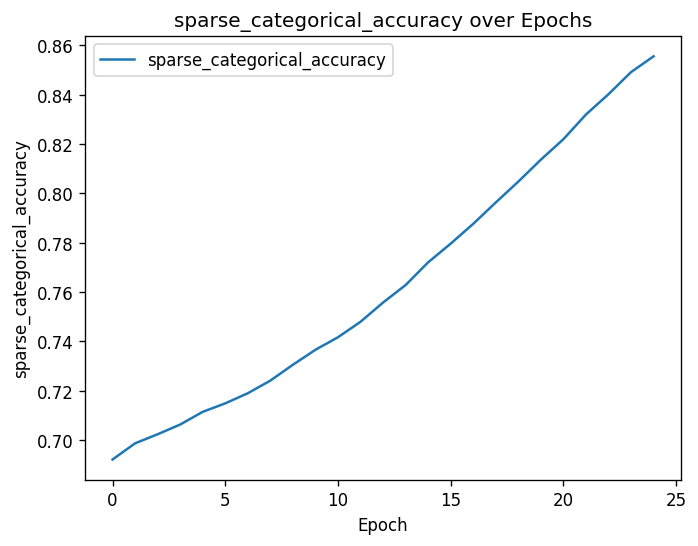

In [24]:
plot_model_metric('sparse_categorical_accuracy')

# Inference After Fine-tuning:

In [25]:
display(Markdown(generate_inference()))

<center><font color='Yellow' size='6'><strong>Input Prompt:</strong></font></center>

<font color='aquamarine' size='4'><strong>System: </strong></font>
You are an AI assistant tasked with answering questions based solely on the provided context. Carefully read the following Context and Question. Your answer must be derived only from the information present in the Context. Do not use any external knowledge or make assumptions beyond what is explicitly stated in the Context.
If the answer to the Question cannot be found within the Context, you must explicitly state: 'The answer cannot be found in the provided context.'

<font color='crimson' size='4'><strong>Question: </strong></font>
Extract the names of Serbian political parties mentioned in the text and put them into a bulleted list.

<font color='cyan' size='4'><strong>Context: </strong></font>
Serbia's electoral system was reformed in 2011, such that parliamentary mandates were awarded in numerical order to candidates on successful lists. Milisavljević received the forty-ninth position on the Democratic Party's Choice for a Better Life list and was re-elected when the list won sixty-seven mandates. The Serbian Progressive Party and the Socialist Party of Serbia formed a new coalition government after the election, and the Democratic Party moved into opposition. In 2013, Milisavljević proposed that the government of Serbia sell its high-powered Mercedes, Audi, and BMW cars in favour of the Fiat 500L model produced in Kragujevac. This proposal received some attention in the Italian media.

<font color='lightgreen' size='4'><strong>Answer: </strong></font>

<center><font color='Yellow' size='6'><strong>Answer as per Dataset:</strong></font></center>

* Democratic Party
* Serbian Progressive Party
* Socialist Party of Serbia

<center><font color='Yellow' size='6'><strong>Gemma 3 Response:</strong></font></center>

Democratic Party, Socialist Party of Serbia

In [26]:
display(Markdown(generate_inference()))

<center><font color='Yellow' size='6'><strong>Input Prompt:</strong></font></center>

<font color='aquamarine' size='4'><strong>System: </strong></font>
You are an AI assistant tasked with answering questions based solely on the provided context. Carefully read the following Context and Question. Your answer must be derived only from the information present in the Context. Do not use any external knowledge or make assumptions beyond what is explicitly stated in the Context.
If the answer to the Question cannot be found within the Context, you must explicitly state: 'The answer cannot be found in the provided context.'

<font color='crimson' size='4'><strong>Question: </strong></font>
What is Project Nimbus?

<font color='cyan' size='4'><strong>Context: </strong></font>
Project Nimbus is a cloud computing project of the Israeli government and its military. The Israeli Finance Ministry announced April 2021, that the contract is to provide "the government, the defense establishment, and others with an all-encompassing cloud solution." Under the contract, the companies will establish local cloud sites that will "keep information within Israel's borders under strict security guidelines."

Project Nimbus has four planned phases: the first is purchasing and constructing the cloud infrastructure, the second is crafting government policy for moving operations onto the cloud, the third is moving operations to the cloud, and the fourth is implementing and optimizing cloud operations. Under a $1.2 billion contract, technology companies Google (Google Cloud Platform) and Amazon (Amazon Web Services) were selected to provide Israeli government agencies with cloud computing services, including artificial intelligence and machine learning.

The terms Israel set for the project contractually forbid Amazon and Google from halting services due to boycott pressure. The tech companies are also forbidden from denying service to any particular government entities.

<font color='lightgreen' size='4'><strong>Answer: </strong></font>

<center><font color='Yellow' size='6'><strong>Answer as per Dataset:</strong></font></center>

Project Nimbus is the Israel government's project and tender process to move all computing from on premise to the cloud for all government entities including the military. The first phase of the $1.2 billion tender process - for the cloud infrastructure - was awarded to Google Cloud Platform (GCP) and Amazon Web Services (AWS), who have built local data centers to ensure all information will remain within Israel's borders under strict security guidelines.

The second phase will involve engaging technology and services companies to develop policy and the third will be to move operations onto the cloud. The fourth and final phase will be implementing and optimising cloud operations leveraging 1st party and 3rd party services available on GCP and AWS cloud platforms available within Israel. 

The terms of the contract forbid Amazon and Google from halting services due to any boycott pressure, or from denying service to any particular government entity including their military.

<center><font color='Yellow' size='6'><strong>Gemma 3 Response:</strong></font></center>

Project Nimbus is a cloud computing project of the Israeli government and its military. The Israeli Finance Ministry announced April 2021, that the contract is being finalized and will provide Israeli government agencies with cloud computing services including artificial intelligence and machine learning.

In [27]:
display(Markdown(generate_inference()))

<center><font color='Yellow' size='6'><strong>Input Prompt:</strong></font></center>

<font color='aquamarine' size='4'><strong>System: </strong></font>
You are an AI assistant tasked with answering questions based solely on the provided context. Carefully read the following Context and Question. Your answer must be derived only from the information present in the Context. Do not use any external knowledge or make assumptions beyond what is explicitly stated in the Context.
If the answer to the Question cannot be found within the Context, you must explicitly state: 'The answer cannot be found in the provided context.'

<font color='crimson' size='4'><strong>Question: </strong></font>
Given this article, what is the largest size for a dead man zone?

<font color='cyan' size='4'><strong>Context: </strong></font>
The dead man zone is the area directly around a bushfire that is likely to burn within five minutes given the current wind conditions or an anticipated change in wind direction. The distance this zone extends from the firefront is highly dependent on terrain, windspeed, fuel type and composition, relative humidity and ambient temperature, and can range from under 100 metres (330 ft) to well over 1 kilometre (3,300 ft).

<font color='lightgreen' size='4'><strong>Answer: </strong></font>

<center><font color='Yellow' size='6'><strong>Answer as per Dataset:</strong></font></center>

The largest size for a dead man zone is 1 kilometre

<center><font color='Yellow' size='6'><strong>Gemma 3 Response:</strong></font></center>

Highly dependent on terrain, windspeed, fuel type and composition